## Preparación

In [1]:
# Importamos todas las librerías que vamos a utilizar en nuestro proyecto

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from catboost import CatBoostRegressor

In [2]:
# Creamos nuestro dataset
# Utilizamos index_col para hacer la columna con las fechas nuestro index
# Utilizamos parse_dates para convertir el tipo de datos de la columna de datos a datetime 

df = pd.read_csv('/datasets/taxi.csv',index_col = [0],parse_dates = [0])

# Organizamos las fechas 

df.sort_index(inplace=True)

In [3]:
# Imprimimos las primeras filas

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Imprimimos las ultimas columnas 

df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
# Imprimimos un Info

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# Imprimimos datos descriptivos 

df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
# Confirmamos duplicados 

df.index.duplicated().any()

False

**Conclusiones**

- Tenemos un dataset de solo dos columnas. Una nos da la fecha en formato ano/mes/día/hora y la otra a cantidad de pedidos de taxi en ese momento.
- Cambiamos el formato de nuestra columna datetime a formato datetime y la volvimos nuestro índice.
- Tenemos 26496 muestras
- No tenemos valores nulos
- No tenemos valores duplicados 
- Tenemos valores de 0. Sin embargo, esto puede estar bien ya que los datos se han tomado cada 10 minutos y puede ser normal que en 10 minutos no hayan pedidos de taxis. No tomaremos esto como outliers.
- Tenemos también valores muy elevados como 119. Estos valores tan elevados podrían ser outliers.


## Análisis

### Outliers

In [8]:
# Definimos nuestra función de outliers

def outliers(df,col,ylabel):
    df.boxplot(col,figsize=(8,5))
    plt.title('Boxplot of ' + col)
    plt.ylabel(ylabel)
    plt.show()

    min = df[col].min()
    values_0 = len(df[df[col] <= 0])
    percentage_values_0 = '{:.2%}'.format(len(df[df[col] <= 0])/len(df))

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    up_limit = Q3 + IQR
    low_limit = Q1 - IQR

    values_up_limit = len(df[df[col] >= up_limit])
    values_low_limit = len(df[df[col] <= low_limit])

    percentage_up_limit = '{:.2%}'.format(len(df[df[col] >= up_limit])/len(df))
    percentage_low_limit = '{:.2%}'.format(len(df[df[col] <= low_limit])/len(df))

    print(df[col].describe())
    print()
    print(f'El IQR de {col} es {IQR}')
    print()

    if low_limit < 0:
        print(f'La cantidad de valores iguales o menores a {min} es {values_0}')
        print()
        print(f'El porcentaje de valores iguales o menores a {min} es {percentage_values_0}')
    else:
        print(f'La cantidad de valores iguales o menores a {low_limit} es {values_low_limit}')
        print()
        print(f'El porcentaje de valores iguales o menores a {low_limit} es {percentage_low_limit}')

    print()
    print(f'EL limite superior es de nuestro boxplot es {up_limit}')
    print()
    print(f'La cantidad de volores iguales o superiores a {up_limit} es {values_up_limit}')
    print()
    print(f'Elporcentaje de valores iguales o superiores a {up_limit} es {percentage_up_limit}')

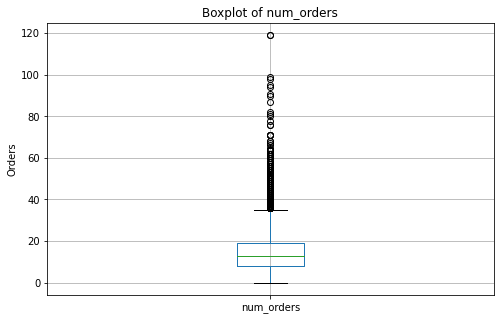

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

El IQR de num_orders es 11.0

La cantidad de valores iguales o menores a 0 es 537

El porcentaje de valores iguales o menores a 0 es 2.03%

EL limite superior es de nuestro boxplot es 30.0

La cantidad de volores iguales o superiores a 30.0 es 1598

Elporcentaje de valores iguales o superiores a 30.0 es 6.03%


In [9]:
# Pasamos nuestra funcion a nuestra columna de num_orders

outliers(df,'num_orders','Orders')

**Conclusiones**
- En efecto tenemos valores extraños en nuestro dataset. Pienso que ya que los valores de 0 tienen un porcentaje bastante bajo con respecto a todo el dataset y sabemos que es posible, no vamos a hacerles nada. 
- Con los valores elevados, se nos es imposible saber que paso con estos valores. Talvez son valores mal anotados o podrían ser reales en caso de que la flota de taxis tenga la capacidad para receptar esa cantidad de pedidos. Si tuvieras más información como la cantidad de taxis con la que cuentan podríamos tener una mejor idea. Por el momento tampoco vamos a hacer nada con estos valores.


**Vamos a analizar no tener valores extraños en nuestro índice.**

In [10]:
df.index.year.unique()

Int64Index([2018], dtype='int64', name='datetime')

In [11]:
df.index.month.unique()

Int64Index([3, 4, 5, 6, 7, 8], dtype='int64', name='datetime')

In [12]:
df.index.week.unique()

/tmp/ipykernel_52/3278054298.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df.index.week.unique()


Int64Index([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
            26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
           dtype='int64', name='datetime')

In [13]:
df.index.day.unique()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64', name='datetime')

In [14]:
df.index.hour.unique()

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='datetime')

**Conclusiones**

- Parece estar todo en order

### Análisis Grafico

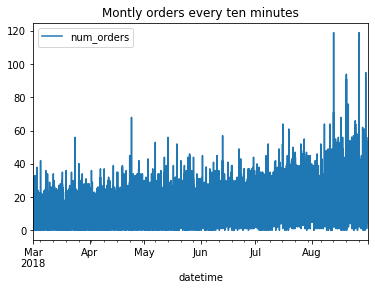

In [15]:
# Creamos un grafico de nuestro dataset

df.plot(title='Montly orders every ten minutes')
plt.show()

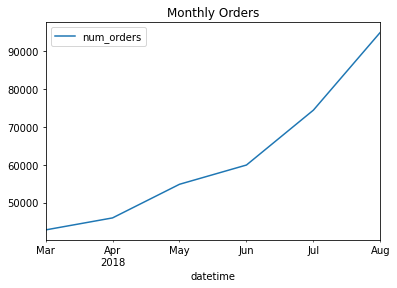

In [16]:
# Creamos un nuevo gráfico por mes

df.resample('1M').sum().plot(title='Monthly Orders')
plt.show()


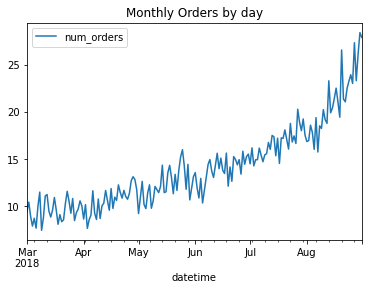

In [17]:
# Creamos un gráfico por día

df.resample('1D').mean().plot(title='Monthly Orders by day')
plt.show()


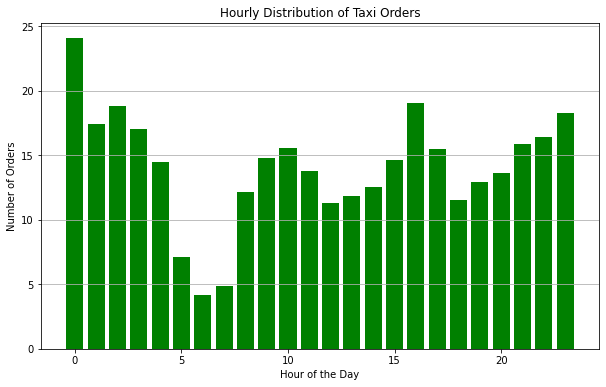

In [18]:
# Creamos un gráfico por hora

hourly_orders = df.copy()
hourly_orders['hour'] = hourly_orders.index.hour

hourly_orders = hourly_orders.groupby('hour').mean()

plt.figure(figsize=(10, 6))
plt.bar(hourly_orders.index, hourly_orders['num_orders'], color='green')
plt.title('Hourly Distribution of Taxi Orders')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.grid(axis='y')
plt.show()

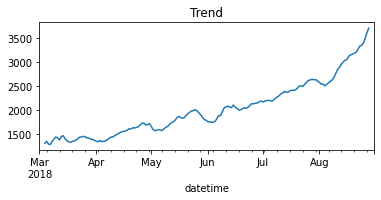

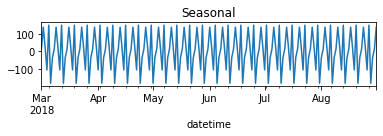

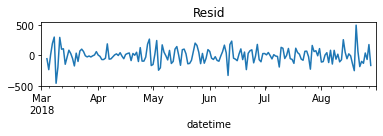

In [19]:
# Creamos un gráficos de tendencia 

decomposed = seasonal_decompose(df.resample('1D').sum())

plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.show()

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resid')
plt.show()

**Conclusiones**
- En nuestro primer grafico no se puede observar muy bien los pedidos. Ya que son cada 10 minutos. Sin embargo, si podemos observar que cada mes tiene sus diferentes picos donde ha habido más cantidad de pedidos. Podemos también ver que a medida que aumentan los meses la cantidad de pedidos aumentan. 
- En nuestro tercer grafico se puede ver muy claramente cómo van aumentando los pedidos de taxi a medida que pasan los meses. 
- En nuestro tercer grafico podemos observar que cada mes tiene sus propias fluctuaciones de días altos y bajos. Sin embargo, también observamos nuevamente que en general aumentan los pedidos mes a mes. 
- Nuestro tercer grafico nos indica las horas en las que, en promedio, hay más pedidos. Observamos que la hora con más pedidos es la media noche. 
- Nuestro ultimo conjunto de datos nos explica la tendencia hallada en nuestros gráficos. Podemos concluir lo mismo que ya se había mencionado que los pedidos han aumentado mes a mes y que cada mes ha tenido sus altos y bajos.


## Creación de Modelos 

In [20]:
# Definimos nuestra función que nos ayudara a crear nuestros features.

def make_features(df, column_name, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] =  df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for i in range(1,max_lag+1):
        df['lag_{}'.format(i)] = df[column_name].shift(i)
    
    df['rolling_mean'] = df[column_name].shift().rolling(rolling_mean_size).mean()

In [21]:
# Creamos nuestros features

make_features(df,'num_orders', 6, 10)

# Utilizamos resample para cambiar la organización de nuestro índice a por horas

df = df.resample('1H').sum()

# Imprimimos las primeras filas

df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,12108,18,6,18,103.0,71.0,51.0,23.0,9.0,0.0,0.0
2018-03-01 01:00:00,85,12108,18,6,18,81.0,94.0,102.0,113.0,122.0,124.0,34.0
2018-03-01 02:00:00,71,12108,18,6,18,92.0,105.0,109.0,107.0,100.0,85.0,98.8
2018-03-01 03:00:00,66,12108,18,6,18,50.0,46.0,50.0,62.0,57.0,71.0,74.9
2018-03-01 04:00:00,43,12108,18,6,18,60.0,67.0,69.0,71.0,71.0,66.0,61.2


In [22]:
# Como tenemos valores ausentes, los eliminamos

df.dropna(inplace=True)

# definimos nuestros features

features = df.drop('num_orders',axis=1)

# definimos nuetro target

target = df['num_orders']

# Dividimos nuestro dataset en conjuntos de entrenamiento y validación.

features_train, features_valid, target_train, target_valid = train_test_split(features,target,shuffle=False,test_size=0.1)

In [23]:
# Definimos nuestra función para calcular el RMSE

def RMSE (y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Linear Regression

In [24]:
model = LinearRegression()
model.fit(features_train,target_train)

predictions_trian = model.predict(features_train)
predictinos_valid =model.predict(features_valid)
print("RMSE para el conjunto de entrenamiento:", RMSE(predictions_trian,target_train))
print("RMSE para el conjunto de prueba:", RMSE(predictinos_valid,target_valid))

RMSE para el conjunto de entrenamiento: 7.475937602415478
RMSE para el conjunto de prueba: 11.30314420989042


### Random Forest Regression

In [25]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state = 12345), param_grid=param_grid, 
    cv=3, scoring='neg_root_mean_squared_error')


grid_search.fit(features_train,target_train)

r_f_best_params = grid_search.best_params_
r_f_best_model = RandomForestRegressor(**r_f_best_params)

r_f_best_model.fit(features_train,target_train)

predict_train_forest = r_f_best_model.predict(features_train)
predict_valid_forest = r_f_best_model.predict(features_valid)

print("RMSE para el conjunto de entrenamiento:", RMSE(predict_train_forest,target_train))
print("RMSE para el conjunto de prueba:", RMSE(predict_valid_forest,target_valid))

RMSE para el conjunto de entrenamiento: 5.024043875055628
RMSE para el conjunto de prueba: 16.92816477429216


### CatBoost

In [26]:
param_grid = {
    'iterations': [100,200,300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
}

grid_search = GridSearchCV(estimator=CatBoostRegressor(), param_grid = param_grid,
                           scoring='neg_mean_squared_error', cv=3)
grid_search.fit(features_train, target_train, eval_set=(features_valid, target_valid))

c_b_best_params = grid_search.best_params_

best_catboost_reg = CatBoostRegressor(**c_b_best_params)

best_catboost_reg.fit(features_train, target_train, eval_set=(features_valid, target_valid))

predict_train_catboost = best_catboost_reg.predict(features_train)
predict_valid_catboost = best_catboost_reg.predict(features_valid)

print("RMSE para el conjunto de entrenamiento:", RMSE(predict_train_catboost,target_train))
print("RMSE para el conjunto de prueba:", RMSE(predict_valid_catboost,target_valid))

0:	learn: 38.5781749	test: 77.6506650	best: 77.6506650 (0)	total: 47.5ms	remaining: 4.7s
1:	learn: 38.2865003	test: 77.1214096	best: 77.1214096 (1)	total: 48.8ms	remaining: 2.39s
2:	learn: 38.0032377	test: 76.6610157	best: 76.6610157 (2)	total: 50.3ms	remaining: 1.62s
3:	learn: 37.7240871	test: 76.2806646	best: 76.2806646 (3)	total: 51.7ms	remaining: 1.24s
4:	learn: 37.4126254	test: 75.7479897	best: 75.7479897 (4)	total: 53.2ms	remaining: 1.01s
5:	learn: 37.1280990	test: 75.2329834	best: 75.2329834 (5)	total: 54.6ms	remaining: 855ms
6:	learn: 36.8391503	test: 74.8241975	best: 74.8241975 (6)	total: 56.1ms	remaining: 746ms
7:	learn: 36.5497538	test: 74.3396696	best: 74.3396696 (7)	total: 57.6ms	remaining: 663ms
8:	learn: 36.2796834	test: 73.8508021	best: 73.8508021 (8)	total: 59.1ms	remaining: 597ms
9:	learn: 36.0015256	test: 73.3216306	best: 73.3216306 (9)	total: 60.5ms	remaining: 545ms
10:	learn: 35.7386328	test: 72.8527794	best: 72.8527794 (10)	total: 61.9ms	remaining: 501ms
11:	learn

**Conclusiones**

- Entrenamos tres modelos distintos. Un modelo de Regresión Lineal, uno de bosque aleatorio, y un CatBoost.
- El mejor RMSE del conjunto de entrenamiento fue el del bosque aleatorio con un RMSE de 5.02.
- El mejor RMSE del conjunto de validación fue el de nuestro modelo de regresión lineal con un RMSE de 11.30. Nuestros otros dos modelos tuvieron un RMSE de 16. 
- Con esto concluimos que el mejor modelo es el modelo de regresión ya que obtuvimos la mejor métrica con los datos de validación.


# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48